<a href="https://colab.research.google.com/github/SyrnikRebirth/qr_code_detector/blob/main/CV6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подтянем картинки

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [20]:
!git clone chto-to-tam

fatal: repository 'chto-to-tam' does not exist


А теперь зафиксируем из в какой папке мы работаем

In [22]:
dataset_path = './drive/MyDrive/TestSet1'

Попробуем найти вложенные друг в друга квадратные контуры. Это должны быть наши Finder Pattern'ы

In [69]:
def img_preprocess(input_img):
    img = input_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # заблюрили изобржение методом гаусса для того чтобы уменьшить шум
    img = cv2.GaussianBlur(img, (9, 9), 0)
    # адаптивная бинаризация чтобы получить хорошее изображение для накидывания поиска контуров
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, 2)
    # еще раз заблюрили 
    img = cv2.medianBlur(img, 9)

    return img

In [67]:
def filter_contours(hierarchy, contours, lower_border, upper_border):
    good_contours_indexes = []

    for i in range(hierarchy.shape[0]):
        element = i
        child_count = 0
        
        while hierarchy[element, 2] != -1:
            element = hierarchy[element, 2]
            child_count += 1

        if lower_border <= child_count <= upper_border:
            good_contours_indexes.append(i)

    return good_contours_indexes

In [ ]:
def detect_find_patterns(hierarchy, contours, good_contours_indexes):
    good_candidates = []
    good_layers = []
    # итерируемся по кандидатам
    for indx in good_contours_indexes:
        family = [indx]
        child = hierarchy[indx, 2]
        while child != -1:
            family.append(child)
            child = hierarchy[child, 2]

        # Для find pattern'ов нас интересуют первые три контура
        cont_a = contours[family[0]]
        cont_b = contours[family[1]]
        cont_c = contours[family[2]]

        # Попытаемся угадаль форму контура
        approx = cv2.approxPolyDP(contours[indx], 0.01*cv2.arcLength(contours[indx], True), True)
        # Если не 4 точки в апроксимированном контуре - то пропускаем
        if len(approx) != 4:
            continue
        # Если фигура, полученная в апроксимации - это квадрат, то мы молодцы
        w = np.sqrt(np.sum((approx[0, 0] - approx[1, 0]) ** 2).astype(float))
        h = np.sqrt(np.sum((approx[1, 0] - approx[2, 0]) ** 2).astype(float))
        if abs(w - h) / min(w, h) > 0.25:
            continue


NameError: ignored

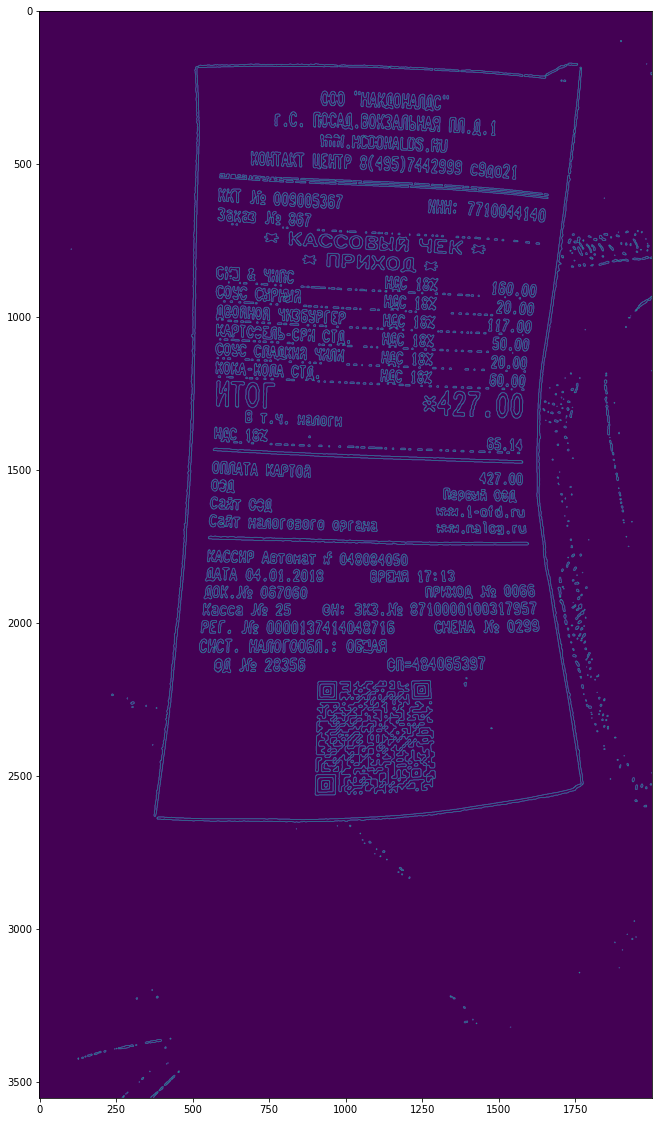

In [71]:
import os
import time
from matplotlib import pyplot as plt


time_start = time.time()
for img_name in os.listdir(dataset_path):
    img = cv2.imread(dataset_path + '/' + img_name, cv2.IMREAD_COLOR)
    # Предобработаем изображение
    preprocessed_img = img_preprocess(img)
    # Найдем грани
    edges = cv2.Canny(preprocessed_img, 80, 120, 7)
    # Используем грани для поиска контуров
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    hierarchy = hierarchy[0]
    # Отфильтруем контуры, избавившись от тех, у кого количество потомков вне обозначенных нами границ
    good_contours_indexes = filter_contours(hierarchy, contours, 4, 7)
    # найдем среди конутров find pattern'ы


    plt.figure(figsize = (50, 20))
    plt.imshow(edges)
    break


    draw_result(data_to_draw)
time_spent = time.time() - time_start

print(f"Time spent:\t{time_spent:.02f} seconds\t({(time_spent / len(img_paths)):.02f} sec/image)")

In [61]:
|

SyntaxError: ignored